<div style="display: flex; align-items: center;">
  <h1 style="font-size: 5em; margin-right: 20px;">Physics Aware Recurrent Convolutional Neural Network: PARC</h1>
  <div>
    <img src="../misc/VIL_logo.png" width="190" alt="Image 1" style="margin-right: 10px;" />
    <img src="../misc/uva.png" width="180" alt="Image 2" style="margin-right: 10px;" />
    <img src="../misc/iowa.png" width="150" alt="Image 3" />
  </div>
</div>

<p>A customizable framework to embed physics in Deep Learning. PARC's formulation is inspired by Advection-Diffusion-Reaction processes and uses an Inductive Bias approach to constrain the Neural Network.</p>


## Normalization

It is assumed that you reviewed the README.md file in our data directory. This provides the format you must convert your data into before normalization (timesteps, channels, height, width). You can find converted data and model weights at: . Then we normalize our variables of interest (channels) between 0 and 1

In [1]:
import sys
import os

# Add the root directory (PARCTorch) to the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from data.normalization import compute_min_max

In [2]:
# Example usage
data_dirs = [
    "/project/vil_baek/data/physics/PARCTorch/NavierStokes/train",
    "/project/vil_baek/data/physics/PARCTorch/NavierStokes/test",
]
output_file = "../data/ns_min_max.json"
compute_min_max(data_dirs, output_file)

Calculating channel-wise min and max values for normalization...
Current working directory: /sfs/gpfs/tardis/home/jtb3sud/PARCtorch/PARCtorch/demos
Total files to process: 36
Processed 36/36 files.
Channel-wise min values: [-255955.37392170238, 15.0, -2.757973022522283, -2.673700584310052]
Channel-wise max values: [109451.57268441282, 10000.0, 4.036231420588235, 2.5842768709241444]
Min and max values saved to '/sfs/gpfs/tardis/home/jtb3sud/PARCtorch/PARCtorch/data/ns_min_max.json'.


## Create Data Loader for Training
<p>The <strong>DataLoader</strong> in PyTorch is a crucial utility that facilitates efficient data handling for training and evaluating machine learning models. It abstracts the process of fetching, batching, and shuffling data, ensuring that the model is fed with properly formatted inputs in an optimal way. Specifically, it helps with:</p>

<ul>
    <li><strong>Batching:</strong> Splitting large datasets into smaller, manageable batches to avoid memory overload and enable parallel processing.</li>
    <li><strong>Shuffling:</strong> Randomly ordering data to prevent the model from learning patterns related to the sequence of data (particularly important in training to reduce overfitting).</li>
    <li><strong>Parallel Loading:</strong> It allows the data to be loaded asynchronously using multiple workers, speeding up the training process by loading the next batch while the current one is being processed by the model.</li>
    <li><strong>Custom Collation:</strong> The <code>collate_fn</code> allows customization of how batches are combined, which is essential for complex datasets that require specific handling.</li>
</ul>


In [3]:
# Now import the utilities
from data.dataset import (
    GenericPhysicsDataset,
    custom_collate_fn,
    InitialConditionDataset,
    initial_condition_collate_fn,
)
from utilities.viz import visualize_channels, save_gifs_with_ground_truth
import torch
from torch.utils.data import DataLoader
import logging

# Set up logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s"
)

# Example configuration for HMX dataset
data_dir_train = "/project/vil_baek/data/physics/PARCTorch/NavierStokes/train"  # Replace with your actual train directory path
data_dir_test = "/project/vil_baek/data/physics/PARCTorch/NavierStokes/test"  # Replace with your actual test directory path
future_steps = 1
# Path to the min_max.json file
min_max_path = os.path.join("..", "data", "ns_min_max.json")  # Correct path
batch_size = 8

# Initialize the dataset
train_dataset = GenericPhysicsDataset(
    data_dirs=[data_dir_train],
    future_steps=future_steps,
    min_max_path=min_max_path,
)

# Create DataLoader for training dataset
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    collate_fn=custom_collate_fn,
)

2024-10-16 14:38:40,272 [INFO] Starting data validation...
2024-10-16 14:38:40,274 [INFO] Validating .npy files...
Validating files: 100%|██████████| 28/28 [00:00<00:00, 340.30it/s]
2024-10-16 14:38:40,361 [INFO] Data validation completed successfully.
2024-10-16 14:38:40,363 [INFO] Preparing dataset samples...
Listing samples: 100%|██████████| 28/28 [00:00<00:00, 475.08it/s]
2024-10-16 14:38:40,426 [INFO] Total samples in dataset: 1064


<h2>Visualize the Data was Loaded Properly</h2>
<p>Users may select a specific visualization scheme for various applications. If you are unsure how to visualize your data, you can explore various options: 
    <a href="https://matplotlib.org/stable/users/explain/colors/colormaps.html" target="_blank">https://matplotlib.org/stable/users/explain/colors/colormaps.html</a>
</p>


Channel Data Statistics:
Channel 0: IC min=0.6993419528007507, IC max=0.7013699412345886
  Step 1: min=0.6994906663894653, max=0.7014170289039612
Channel 1: IC min=0.008512768894433975, IC max=0.008512768894433975
  Step 1: min=0.008512768894433975, max=0.008512768894433975
Channel 2: IC min=0.37832126021385193, IC max=0.649697482585907
  Step 1: min=0.3333809971809387, max=0.6466608643531799
Channel 3: IC min=0.3567461371421814, IC max=0.6603120565414429
  Step 1: min=0.35497817397117615, max=0.6620773673057556


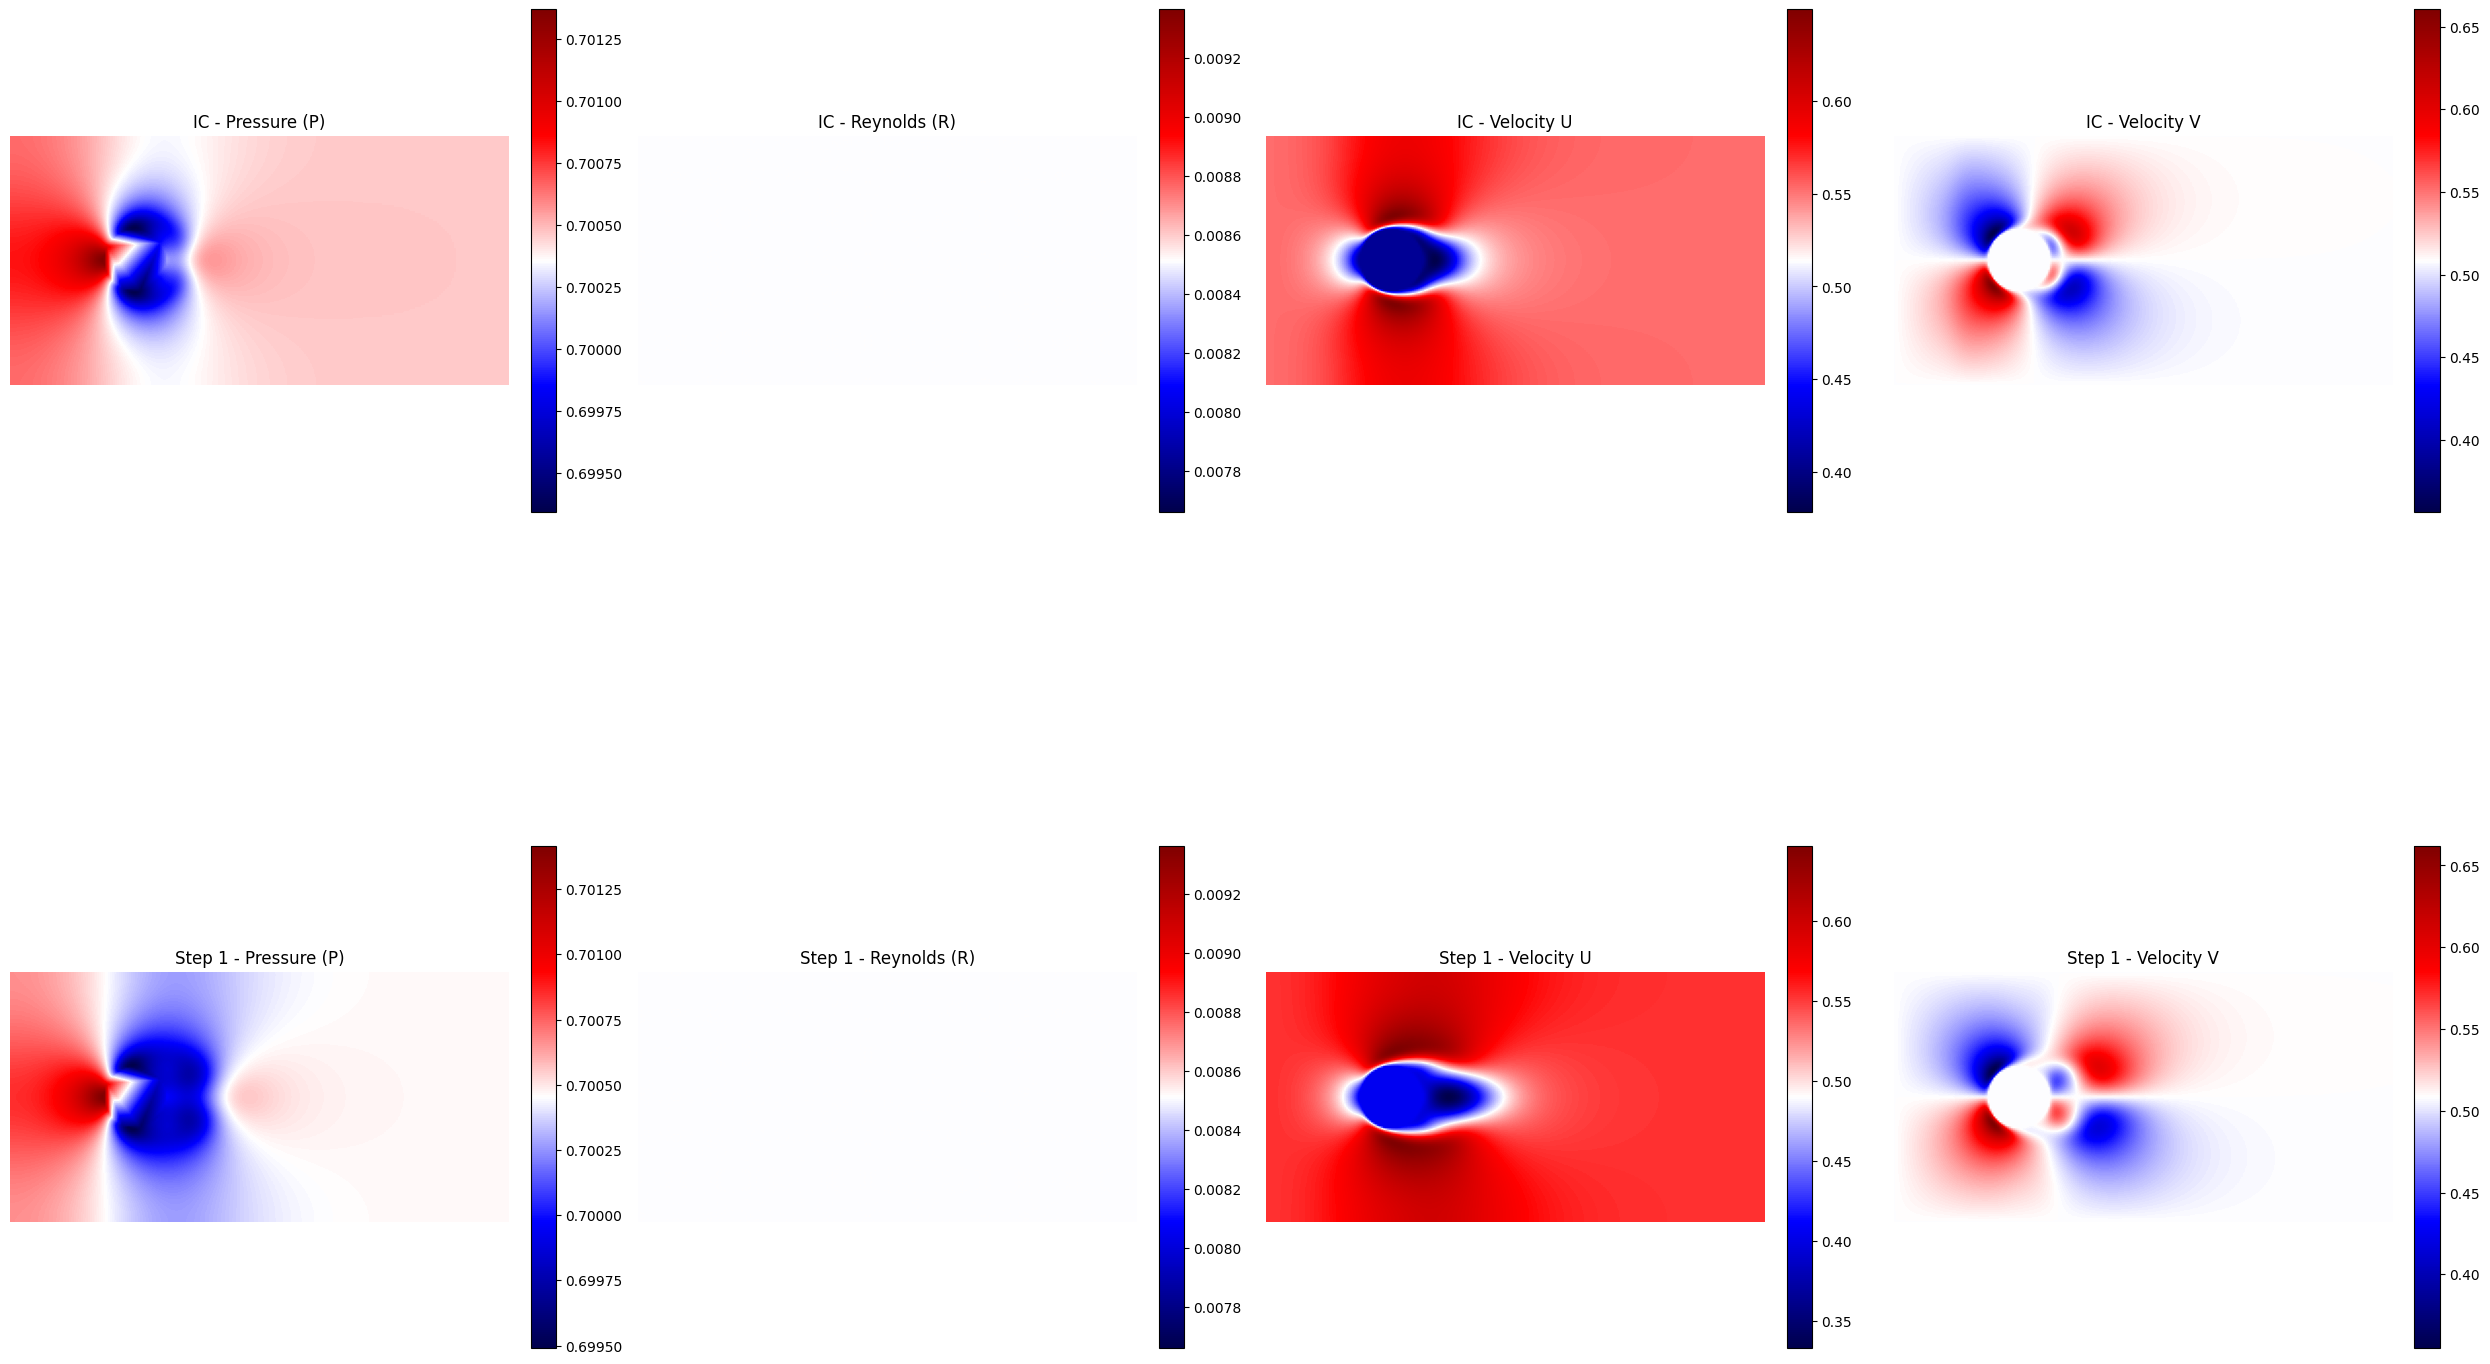

In [4]:
# Fetch a batch and visualize
for batch in train_loader:
    ic, t0, t1, target = batch
    channel_names = [
        "Pressure (P)",
        "Reynolds (R)",
        "Velocity U",
        "Velocity V",
    ]
    custom_cmaps = ["seismic", "seismic", "seismic", "seismic"]

    visualize_channels(
        ic,
        t0,
        t1,
        target,
        channel_names=channel_names,
        channel_cmaps=custom_cmaps,
    )
    break  # Visualize one batch for now

<h2>Build Your PARC Model</h2>
<p>In this section, we are constructing a <strong>PARCv2 model</strong>, which is designed to handle spatiotemporal data, such as fluid dynamics simulations. The model leverages various components, including <em>differentiators</em> and <em>integrators</em>, to solve physical equations like Navier-Stokes.</p>

<p><strong>Key Components:</strong></p>
<ul>
    <li><strong>UNet:</strong> The UNet architecture is used for feature extraction, transforming the input data into a higher-dimensional representation. This helps the model capture complex patterns in the physical simulation data.</li>
    <li><strong>FiniteDifference:</strong> This differentiator approximates the gradients (or derivatives) of the input data using a finite difference method, which is important for calculating advection and diffusion processes in fluid dynamics.</li>
    <li><strong>Heun Integrator:</strong> Heun’s method is an improved version of Euler's method, used here to integrate the equations of motion more accurately over time.</li>
    <li><strong>Differentiator:</strong> This module calculates the advection and diffusion terms based on specific channel indices, such as velocity in the x and y directions (u and v).</li>
    <li><strong>Integrator:</strong> The integrator applies Heun’s method to combine the differentiated terms and solve the Poisson equation, ensuring the physical constraints of the system are respected.</li>
</ul>

<p>The model is then wrapped into the <strong>PARCv2</strong> class, which combines the differentiator, integrator, and loss function (<code>L1Loss</code>). Finally, an <code>Adam</code> optimizer is initialized to train the model by adjusting its parameters to minimize the error between predictions and ground truth data.</p>

<p>This setup allows the model to learn how to predict future states in complex physical systems by embedding domain-specific knowledge.</p>


In [5]:
import sys

sys.path.append("../../")

In [6]:
from PARCtorch.PARCv2 import PARCv2
from PARCtorch.differentiator.differentiator import Differentiator
from PARCtorch.differentiator.finitedifference import FiniteDifference
from PARCtorch.integrator.integrator import Integrator
from PARCtorch.integrator.heun import Heun
from PARCtorch.utilities.unet import UNet

In [7]:
from torch.optim import Adam

In [8]:
# Defining Navier-Stokes variables: 
# p = pressure, re = Reynolds number, u = velocity in x-direction, v = velocity in y-direction
# Advection (Adv) and Diffusion (Dif) will be calculated on u, v
# Poisson equation (Poi) will be calculated on pressure (p)

n_fe_features = 128  # Number of features extracted by the UNet

# Initialize the UNet architecture for feature extraction
unet_ns = UNet(
    [64, 64 * 2, 64 * 4, 64 * 8, 64 * 16],  # Channel dimensions at different levels of the UNet
    4,  # Number of input channels: p, re, u, v
    n_fe_features,  # Number of output features (feature extraction capacity)
    up_block_use_concat=[False, True, False, True],  # Control whether to use concatenation in upsampling blocks
    skip_connection_indices=[2, 0],  # Indices of skip connections for UNet (residual connections)
)

# Initialize finite difference method for numerical differentiation
right_diff = FiniteDifference(padding_mode="replicate").cuda()  # Use replication padding to handle boundary conditions

# Initialize Heun's method for numerical integration
heun_int = Heun().cuda()  # Heun's method is a second-order integrator (similar to improved Euler's method)

# Create the Differentiator, responsible for calculating advection and diffusion
diff_ns = Differentiator(
    2,  # Number of state variables (p, re), with u and v as velocity channels (indices 2 and 3)
    n_fe_features,  # Number of features returned by the feature extraction network
    [2, 3],  # Channel indices for advection calculation (u, v)
    [2, 3],  # Channel indices for diffusion calculation (u, v)
    unet_ns,  # Feature extraction network (UNet used to extract features from the state variables)
    "constant",  # Padding mode: constant padding (zeros at the boundary)
    right_diff,  # Use finite difference method for gradient calculations
    False # Random noise for Spade
).cuda()

# Create the Integrator, responsible for solving the Poisson equation and performing integration
ns_int = Integrator(
    True,  # Clip the input data between 0 and 1 to prevent extreme values
    [(0, 2, 3, 1)],  # Calculate Poisson on indices u and v (2 and 3), output the result to p (index 0)
    heun_int,  # Use Heun's method for integration of the Navier-Stokes equations
    [None, None, None, None],  # No additional data-driven integrators for now
    "constant",  # Padding mode: constant padding of zero at boundaries
    right_diff,  # Finite difference method for handling derivatives
).cuda()

# Define the loss function (L1 Loss is typically used for regression tasks)
criterion = torch.nn.L1Loss().cuda()

# Initialize the PARCv2 model with the differentiator, integrator, and loss function
model = PARCv2(diff_ns, ns_int, criterion).cuda()

# Set up the optimizer (Adam is a popular choice for adaptive learning rate optimization)
optimizer = Adam(model.parameters(), lr=1e-5)  # Learning rate set to 1e-5


## Train the Model 

In [9]:
from train import train_model

# Example usage:
train_model(
    model,
    train_loader,
    criterion,
    optimizer,
    num_epochs=1,
    save_dir="home/jtb3sud/hold/testnavier_stokes",
)


Epoch 1/1: 100%|██████████| 133/133 [00:28<00:00,  4.70it/s, Batch Loss=0.314]  

Epoch [1/1], Average Loss: 0.0800
Model weights saved at home/jtb3sud/hold/testnavier_stokes/model.pth


## Load the Model

In [14]:
from utilities.load import load_model_weights


# Example Usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_weights_path = (
    "/home/jtb3sud/hold/testnavier_stokes/model.pth"  # Replace with your path
)
model = load_model_weights(model, model_weights_path, device)

Loaded model weights from '/home/jtb3sud/hold/testnavier_stokes/model.pth'


## Create the Sequence DataLoader
### This will contain the t=0 for each test file

In [11]:
# Initialize the dataset
future_steps = 10
seq_dataset = InitialConditionDataset(
    data_dirs=[data_dir_test],
    future_steps=future_steps,
    min_max_path=min_max_path,
)

# Create DataLoader for training dataset
seq_loader = DataLoader(
    seq_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    collate_fn=initial_condition_collate_fn,
)

2024-10-16 14:39:15,051 [INFO] Starting data validation...
2024-10-16 14:39:15,055 [INFO] Validating .npy files...
Validating files: 100%|██████████| 8/8 [00:00<00:00, 336.25it/s]
2024-10-16 14:39:15,083 [INFO] Data validation completed successfully.
2024-10-16 14:39:15,084 [INFO] Validating timesteps in each file...
Validating timesteps: 100%|██████████| 8/8 [00:00<00:00, 699.62it/s]


## Ground truth loader

In [12]:
# Initialize the dataset
gt_dataset = GenericPhysicsDataset(
    data_dirs=[data_dir_test],
    future_steps=future_steps,
    min_max_path=min_max_path,
)

# Create DataLoader for training dataset
gt_loader = DataLoader(
    gt_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    collate_fn=custom_collate_fn,
)

2024-10-16 14:39:15,103 [INFO] Starting data validation...
2024-10-16 14:39:15,107 [INFO] Validating .npy files...
Validating files: 100%|██████████| 8/8 [00:00<00:00, 630.11it/s]
2024-10-16 14:39:15,124 [INFO] Data validation completed successfully.
2024-10-16 14:39:15,125 [INFO] Preparing dataset samples...
Listing samples: 100%|██████████| 8/8 [00:00<00:00, 761.79it/s]
2024-10-16 14:39:15,139 [INFO] Total samples in dataset: 232


## Visualize the Results

In [13]:
# Set the model to evaluation mode
model.eval()

# Define channel names and colormaps
channels = ["pressure", "Reynolds", "u", "v"]  # Adjust as per your data
cmaps = [
    "viridis",
    "plasma",
    "inferno",
    "magma",
]  # Adjust as per your preference

# Iterate through both DataLoaders simultaneously
for seq_batch, test_batch in zip(seq_loader, gt_loader):
    # Extract data from initial condition loader
    ic, t0, t1, _ = (
        seq_batch  # Shape: [batch_size, channels, height, width], scalar, tensor, _
    )

    # Extract data from ground truth loader
    gt_ic, gt_t0, gt_t1, ground_truth = (
        test_batch  # ground_truth shape: [timesteps, batch_size, channels, height, width]
    )

    # Move data to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ic = ic.to(device)
    t0 = t0.to(device)
    t1 = t1.to(device)
    ground_truth = ground_truth.to(device)

    # Make predictions using the model
    with torch.no_grad():
        predictions = model(
            ic, t0, t1
        )  # Shape: [future_steps, batch_size, channels, height, width]

    print("Predictions shape:", predictions.shape)
    print(
        "Sample prediction for timestep 1:", predictions[:, 0, :, :, :].shape
    )

    # If you want to visualize more samples in the batch, loop through batch indices
    # For example, to visualize all samples in the batch:
    for batch_idx in range(ic.size(0)):
        save_gifs_with_ground_truth(
            predictions=predictions,
            ground_truth=ground_truth,
            channels=channels,
            cmaps=cmaps,
            filename_prefix=f"comparison_batch{batch_idx}",
            interval=0.2,
            batch_idx=batch_idx,
        )
        break

    break  # Remove this if you want to process the entire dataset

Predictions shape: torch.Size([10, 8, 4, 128, 256])
Sample prediction for timestep 1: torch.Size([10, 4, 128, 256])
GIF saved to comparison_batch0_pressure.gif
GIF saved to comparison_batch0_Reynolds.gif
GIF saved to comparison_batch0_u.gif
GIF saved to comparison_batch0_v.gif
